In [88]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.optimize import linprog

# Notes
- Make a good bibliography (think about paper/board)
- Add low temp RH and high temp RH to monthly plot 
- Change low and high temp times from the max/min temp to the time of the average max/min temp 
- Digitize two more MOFs (MOF 841 and whatever the other one is)


## Read in Adsorption Data

In [89]:
R = 8.314 # universal gas constant [J/(mol-K)]

#define MOF list and corresponding data temperatures
MOFs = ['CAU_23','MIP_200','KMF_1','MOF_801','Co_CUK_1','MIL_160']
data_temperatures = [25, 20, 20, 25, 20, 20 ]

In [90]:
"""
    read_ads_data(mof, temperature)

mof (string): name of MOF
temperature (integer): in degree C
"""
def read_ads_data(mof, temperature):
    # reads adsorption isotherm data
    ads_data = pd.read_csv('data/{}_{}C.csv'.format(mof, temperature))

    # if the first row is zero RH, drop it.
    if ads_data['RH[%]'][0] == 0:
        ads_data = ads_data.drop(0)
        ads_data = ads_data.reset_index(drop=True)

    # convert humidity to P/P_0
    if ads_data['RH[%]'].iloc[-1] > 1: # truly a percent
        ads_data['P/P_0'] = ads_data['RH[%]'] / 100
    else: # RH ranges from 0 to 1
        ads_data['P/P_0'] = ads_data['RH[%]']

    # Gets rid of the Humidity column, now we're using P/P_0
    ads_data = ads_data.drop(columns=['RH[%]']) 
    
    # Polanyi adsorption potential for every P/P_0 in the data set
    ads_data["A [kJ/mol]"] = -R * (temperature + 273.15) * np.log(ads_data['P/P_0']) / 1000.0
   
    return ads_data

In [91]:
my_ads_data = read_ads_data("MOF_801", 25) # example
my_ads_data

,Water Uptake [kg kg-1],P/P_0,A [kJ/mol]
0,0.001,0.00114,16.798280
1,0.012,0.04805,7.524488
2,0.116,0.09840,5.747674
3,0.209,0.14874,4.723527
4,0.231,0.19680,4.029487
5,0.247,0.24714,3.464894
6,0.258,0.29748,3.005341
7,0.278,0.40046,2.268470
8,0.298,0.49886,1.723845
9,0.321,0.59954,1.268145


# Polyanyi adsorption theory
to predict water adsorption in a MOF at different T, P/P_0

In [92]:
"""
    characteristic_curve(ads_data)

returns interpolator of the data giving the characteristic curve,
which is the water uptake as a function (kg/kg) of Polynami adsorption potential A (kJ/mol).
NOTE: This is the most important part

"""
def characteristic_curve(ads_data): 

    # sort rows by A values
    ads_data = ads_data.sort_values('A [kJ/mol]') 

    x = ads_data['A [kJ/mol]'].values
    y = ads_data['Water Uptake [kg kg-1]'].values
    
    #n_of_A = interpolate.interp1d(x, y, kind='cubic', fill_value="extrapolate" )
    #n_of_A = interpolate.CubicSpline(x, y, bc_type='natural', extrapolate=True)
    n_of_A = interpolate.PchipInterpolator(x, y)
    #n_of_A = interpolate.Akima1DInterpolator(x, y)


    return n_of_A

In [93]:
my_char_curve = characteristic_curve(my_ads_data)
plt.show()

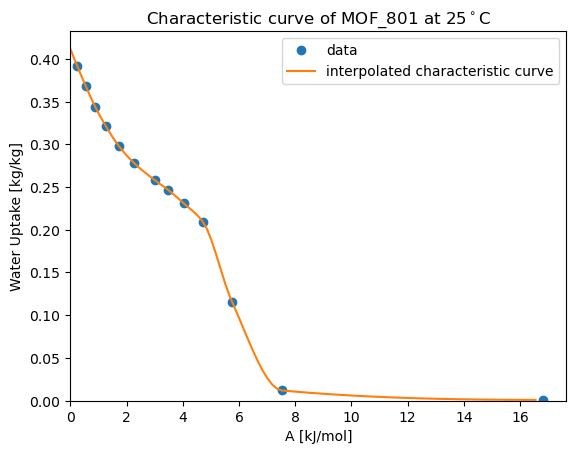

In [94]:
ads_data = read_ads_data("MOF_801", 25)
ads_range = abs(ads_data['A [kJ/mol]'].max() - ads_data['A [kJ/mol]'].min())
A_range = np.linspace(0, ads_range, 100)
n_of_A = characteristic_curve(ads_data)
plt.plot(ads_data['A [kJ/mol]'], ads_data['Water Uptake [kg kg-1]'], 'o', label='data')
plotted_curve = [n_of_A(A_vals) for A_vals in A_range]
plt.plot(A_range, plotted_curve, label = 'interpolated characteristic curve')
plt.title('Characteristic curve of MOF_801 at 25$^\circ$C')
plt.xlabel('A [kJ/mol]')
plt.ylabel('Water Uptake [kg/kg]')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()
plt.show()


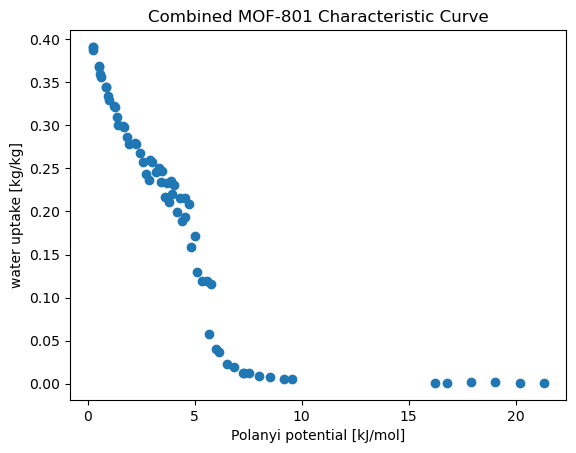

In [95]:
# Reads all of the different temp MOF 801 isotherms 
ads_data_15 = read_ads_data('MOF_801',15)
ads_data_25 = read_ads_data('MOF_801',25)
ads_data_45 = read_ads_data('MOF_801',45)
ads_data_65 = read_ads_data('MOF_801',65)
ads_data_85 = read_ads_data('MOF_801',85)
ads_data_105 = read_ads_data('MOF_801',105)

combined_df = pd.concat([ads_data_15, ads_data_25, ads_data_45, ads_data_65, ads_data_85,ads_data_105]) # Combines all MOF 801 data into a single dataframe 

plt.scatter(combined_df['A [kJ/mol]'], combined_df['Water Uptake [kg kg-1]'])
plt.title('Combined MOF-801 Characteristic Curve')
plt.xlabel('Polanyi potential [kJ/mol]')
plt.ylabel('water uptake [kg/kg]')
plt.show()

# Proving of theory with MOF 801

In [96]:
'''
    check_characteristic_curve(data_temp)
        check the accuracy of the characteristic curve and interpolation by comparing the original data with the interpolated data

data_temp(int): temperature of the data the characteristic curve is based on
check_temp(int): temperature of the data to be checked
Options are 15, 25 ,45, 65, 85, 105
'''

def check_characteristic_curve(data_temp,check_temp):
    ads_data = read_ads_data("MOF_801", data_temp)
    n_of_A = characteristic_curve(ads_data)
    

    current_ads_data = read_ads_data("MOF_801", check_temp)
    current_ads_data.insert(1,'Calculated Adsorption',n_of_A(current_ads_data['A [kJ/mol]']),True) 
    #current_ads_data.insert(2, 'Percent Error', abs(current_ads_data['Water Uptake [kg kg-1]'] - current_ads_data['Calculated Adsorption'])
    #/current_ads_data['Water Uptake [kg kg-1]'], True)
    
    plt.scatter(ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'], label='Original Data')
    plt.plot(current_ads_data['P/P_0'], current_ads_data['Calculated Adsorption'],c='orange', label='Calculated Data from {}$^\circ$C Curve'.format(data_temp))
    plt.title('Adsorption Isotherm Comparison at {}$^\circ$C'.format(check_temp))
    plt.xlabel('P/P_0')
    plt.ylabel('Water Uptake [kg/kg]')
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.legend()

    
    #err = current_ads_data['Percent Error'].mean()

    # print(current_ads_data)
    #print('Mean error between curves: {}'.format(err))




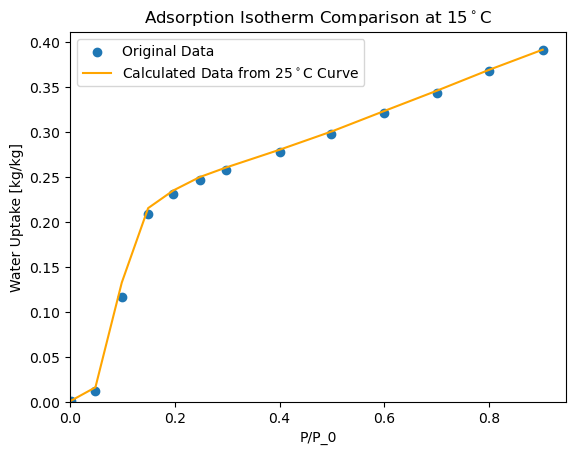

In [97]:
check_characteristic_curve(25,15)

Error Between curves is likely due to the large gaps in the characteristic curve at large potential values

In [98]:
"""
    predict_water_adsorption(T, P_over_P_0, n_of_A)

use Polyanyi potential to predict water adsorption in a MOF, 
given the temperature, P/P_0, and the characteristic curve.

to do so, we 
(i) calculate the Polyanyi potential
(ii) look up the water adsorption at that potential, on the char. curve.
"""
def predict_water_adsorption(T, P_over_P_0, n_of_A):
    # Calculate the Polanyi potential 
    A = -R * (T + 273.15) * np.log(P_over_P_0) / 1000.0
    # compute water adsorption at this A on the char. curve
    w = n_of_A(A).item() 
    return w # kg/kg

In [99]:
predict_water_adsorption (25.0, 0.29748, my_char_curve) # should be 0.258

0.258

# Explore MOF Adsorption Data
data sources:
* MOF-801 [link](oregonstate.edu)

### plot adsorption isotherms

In [100]:
"""
plot the adsorption isotherm for a given MOF and temperature. 
    for a single MOF, it needs it as a range of the lists, so to access 'DUT_67', use [0:1]
"""
def viz_ads_isotherms(MOFs, data_temperatures):
    plt.figure()
    plt.title('water adsorption isotherms')
    plt.xlabel('relative humidity, P/P_0')
    plt.ylabel('water uptake [kg/kg]')
    for i in range(len(MOFs)):
        ads_data = read_ads_data(MOFs[i], data_temperatures[i]) # pull the file and calculate A values 
        plt.plot(
            ads_data['P/P_0'], ads_data['Water Uptake [kg kg-1]'],
            label="{} {}$^\circ$C".format(MOFs[i], data_temperatures[i]),
            marker="o"
        )
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.legend(prop={'size': 8})
    plt.show()

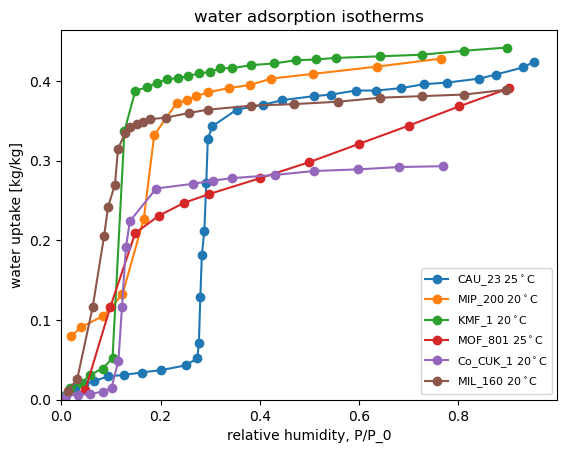

In [101]:
viz_ads_isotherms(MOFs, data_temperatures)

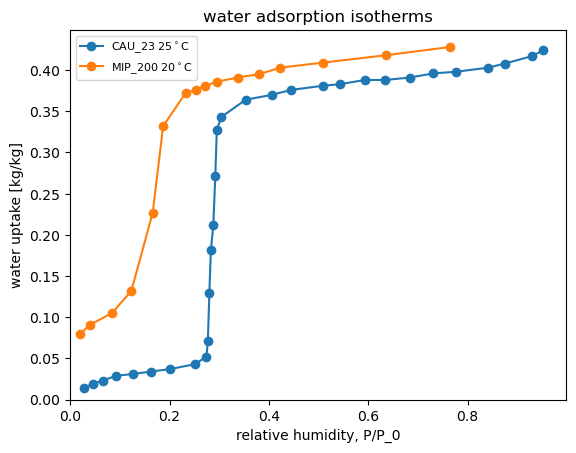

In [102]:
# Fix with MOF string only 
viz_ads_isotherms(MOFs[0:2], data_temperatures[0:2]) 

### plot characteristic curves

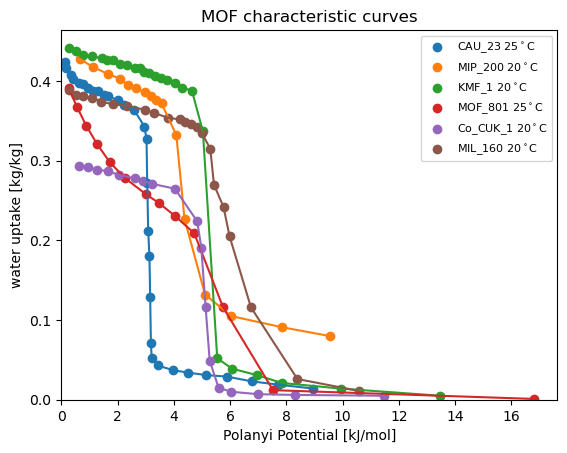

In [103]:
'''
    view_characteristic_curve(mof, data_temp)
        takes MOFs: MOFs[int:int]  
        data_temperatures: data_temperatures[int:int]

        NOTE: graph shows lines between points, not the true curve n_of_A

'''

def view_characteristic_curve(MOFs, data_temperatures): # view the characteristic curve for a given MOF and temperature 
    
    plt.figure()
    plt.title('MOF characteristic curves')
    plt.xlabel('Polanyi Potential [kJ/mol]')
    plt.ylabel('water uptake [kg/kg]')
    for i in range(len(MOFs)):
        ads_data = read_ads_data(MOFs[i], data_temperatures[i]) # pull the file and calculate A values 
        n_of_A = characteristic_curve(ads_data)
        plt.scatter(
            ads_data['A [kJ/mol]'], n_of_A(ads_data['A [kJ/mol]']),
            label="{} {}$^\circ$C".format(MOFs[i], data_temperatures[i]),
            marker="o"
        )        
        plt.plot(
            ads_data['A [kJ/mol]'], n_of_A(ads_data['A [kJ/mol]']))
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.legend(prop={'size': 8})

view_characteristic_curve(MOFs, data_temperatures)

# Read Weather data 

[source](https://www.weather.gov/wrh/timeseries?site=kphx) for weather data, can only access 1 month at a time 

[source](https://www.weather.gov/media/epz/wxcalc/tempConvert.pdf) for conversion from F to C 

In [104]:
'''
    read_weather_data(location_month_year)
        given a location, month, and year, reads the weather data for that location and time period
        converts from ferenheit to celsius for both air temperature and dewpoint 
        converts relative humidity from percentage to fraction
'''

def read_weather_data(location_month_year):
    df_weather = pd.read_csv('data/PHX_06_2024.csv')
    df_weather['Temperature'] = (df_weather['Temperature'] - 32) * 5/9
    df_weather['Dew Point'] = (df_weather['Dew Point'] - 32) * 5/9
    df_weather['Relative Humidity'] = df_weather['Relative Humidity'] / 100

    return df_weather



In [105]:
df_weather = read_weather_data('PHX_06_2024')
df_weather

,Date,Time,Temperature,Dew Point,Relative Humidity
0,5/31/2024,17:00:00,41.0,-7.361111,0.0432
1,5/31/2024,17:50:00,40.0,-6.427778,0.0492
2,5/31/2024,18:35:00,39.0,-4.511111,0.0605
3,5/31/2024,19:20:00,39.0,-2.538889,0.0703
4,5/31/2024,20:05:00,38.0,-5.522222,0.0592
...,...,...,...,...,...
910,6/30/2024,13:40:00,41.0,16.288889,0.2342
911,6/30/2024,14:25:00,41.0,15.300000,0.2197
912,6/30/2024,15:10:00,43.0,16.361111,0.2109
913,6/30/2024,15:55:00,42.0,15.327778,0.2084


In [106]:
''' 
    retrieve_high_low(date)
        
        date (string): mm/dd/yyyy    
    
        given a date, find the high and low temperatures for that day 
        assign them to a day collectively
        we don't neccesarily need the time, so it's commented out 

'''
def retrieve_high_low(date):

    high_loc = df_weather.loc[df_weather['Date'] == date, 'Temperature'].idxmax()
    high_t = df_weather.loc[high_loc, 'Temperature']
    # high_time = df_weather.loc[high_loc, 'Time']
    high_RH = df_weather.loc[high_loc, 'Relative Humidity']

    low_loc = df_weather.loc[df_weather['Date'] == date, 'Temperature'].idxmin()
    low_t = df_weather.loc[low_loc, 'Temperature']
    # low_time = df_weather.loc[low_loc, 'Time']
    low_RH = df_weather.loc[low_loc, 'Relative Humidity']

    return high_t, high_RH, low_t, low_RH


<Figure size 640x480 with 0 Axes>

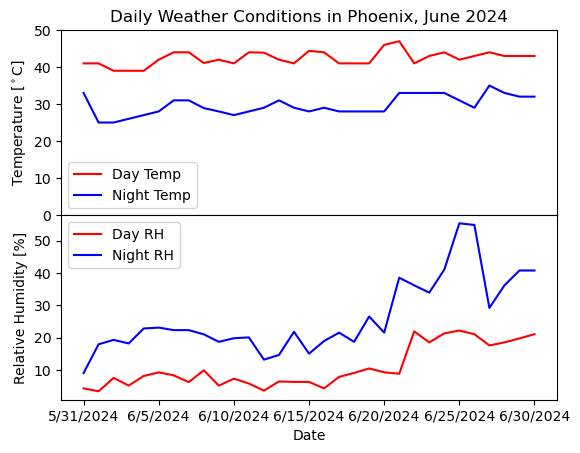

In [119]:
'''
    plot_monthly_weather(df_weather)
'''
def plot_monthly_weather(df_weather):
    date_list = df_weather['Date'].unique()
        
    high_temps = [retrieve_high_low(date)[0] for date in date_list]
    high_RH = [retrieve_high_low(date)[1] for date in date_list]
    high_RH = np.array(high_RH) * 100
    low_temps = [retrieve_high_low(date)[2] for date in date_list]
    low_RH = [retrieve_high_low(date)[3] for date in date_list]
    low_RH = np.array(low_RH) * 100
   
    plt.figure()

    fig, axs = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)

    axs[0].plot(date_list, high_temps, c='red', label='Day Temp')
    axs[0].plot(date_list, low_temps, c='blue', label='Night Temp')
    axs[0].set_yticks(np.arange(0, 60, 10))
    axs[0].set_title('Daily Weather Conditions in Phoenix, June 2024')
    axs[0].set_ylabel('Temperature [$^\circ$C]')
    axs[0].legend()



    axs[1].plot(date_list, high_RH, c='red', label='Day RH')
    axs[1].plot(date_list, low_RH, c='blue', label='Night RH')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Relative Humidity [%]')
    axs[1].set_xticks(date_list[::5])
    axs[1].legend()

    plt.show()


    return

plot_monthly_weather(df_weather)


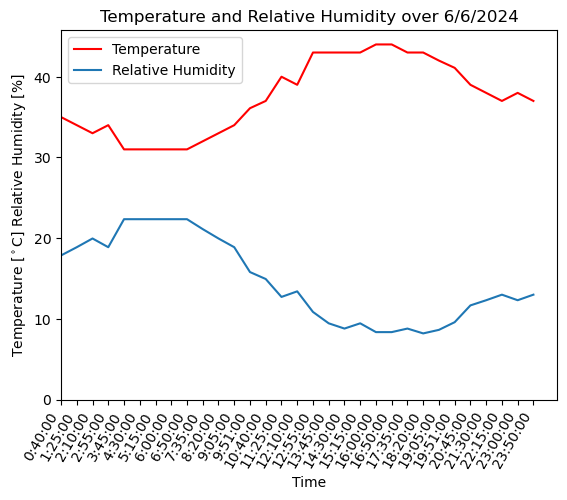

In [108]:
'''
    plot_day(day)
        given a day in june, view the daily temp and RH as a function of time 

    NOTE: find a way to make a regualr x-axis with time
    also maybe find a way to plot over a range of days 

'''
def plot_over_date(date):

    df_date = df_weather[df_weather['Date'] ==  date]
    plt.plot(df_date['Time'], df_date['Temperature'],c='red', label = 'Temperature')
    plt.plot(df_date['Time'], df_date['Relative Humidity'] * 100, label = 'Relative Humidity')
    plt.xlabel('Time')
    plt.xticks(rotation=60, ha='right')
    plt.ylabel('Temperature [$^\circ$C] Relative Humidity [%]')
    plt.title('Temperature and Relative Humidity over {}'.format(date))
    plt.xlim(xmin=0)
    plt.ylim(ymin = 0)
    plt.legend()
    plt.show()

plot_over_date('6/6/2024')


In [109]:
retrieve_high_low('6/4/2024')

(39.0, 0.0815, 26.999999999999996, 0.2286)

# Calculate Water Output 

In [110]:
''' 
    water_daily(day,MOF)
        Given weather conditions and a MOF find the rate of mass of water produced 
        assuming the MOF is allowed to reach equilibrium 

        day (string): mm/dd/yyyy
        MOF (string): name of MOF
        temp (float): temperature of MOF data [C]
''' 

def calculate_daily_ads(date,MOF,temp): 
    
    ads_data = read_ads_data(MOF, temp)

    n_of_A = characteristic_curve(ads_data)

    high_t, high_RH, low_t, low_RH = retrieve_high_low(date)

    # A_low = -R * (low_t+273.15) * np.log(low_RH) # calculate polanyi potential during daily high
    
    # A_high = -R * (high_t+273.15) * np.log(high_RH) # calculate polanyi potential during daily low
    
    high_water = predict_water_adsorption(high_t, high_RH, n_of_A)  # calculate adsorption value during daily high
    
    low_water = predict_water_adsorption(low_t, low_RH, n_of_A) # calculate adsorption value during daily low (should be higher than during daily high)
    
    water_rate = low_water - high_water # compare the high and low values to find amount of water kicked off by MOF over the course of a day per kg MOF 
    
    water_mass = water_rate * 1 # multiply by 1 to find the mass of water collected by the MOF per day [kg/day]
    
    #print('The mass of water collected by the MOF per day during week', week, 'is',round(water_mass,4),'[kg/day]')

    return water_mass

In [111]:
calculate_daily_ads ('6/6/2024','MOF_801',25)

0.1830271858032122

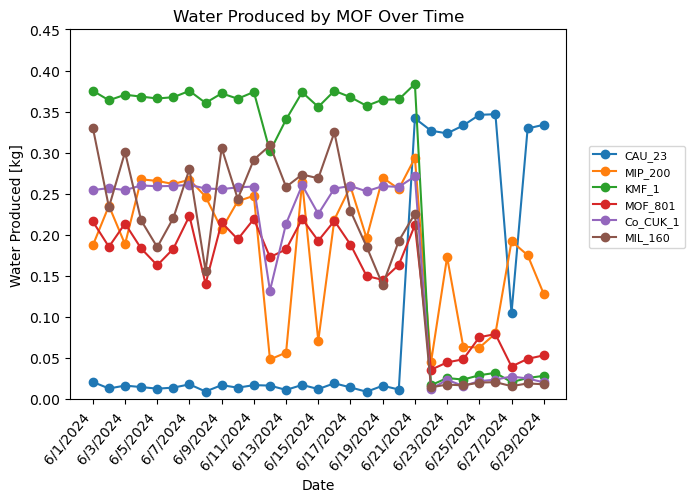

In [112]:
'''
    water_over_time(date1,date2,MOF,mass_MOF)
        given a start and end date, a MOF, and the mass of the MOF, plot the water produced by the MOF over time 
        for each day in the range, calculate the water produced by the MOF and plot it 

'''

def water_over_time(date1,date2,MOF) -> np.array:
    MOF_loc = MOFs.index(MOF)
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)
    delta = date2 - date1
    delta = delta.days

    day_list = [date1 + pd.DateOffset(days=x) for x in range(delta+1)]
    day_list = [day.strftime('%#m/%#d/%Y') for day in day_list]
    list_range = range(len(day_list)-1)
    water_list = [calculate_daily_ads(day_list[z],MOF,data_temperatures[MOF_loc]) for z in list_range]
    
    

    
    plt.plot(day_list[0:delta],water_list,marker="o",label = MOF)
    plt.xlabel('Date')
    plt.xticks(day_list[::2],rotation=50, ha='right')
    plt.ylabel('Water Produced [kg]')
    plt.ylim(0,0.45)
    plt.title('Water Produced by MOF Over Time')
    plt.legend(bbox_to_anchor=(1.25,0.7),prop={'size': 8})

    
    return 


for i in range(len(MOFs)):
    water_over_time('6/1/2024','6/30/2024',MOFs[i])



## OPTIMIZATION ##

one minimizes the total mass of MOF needed to produce a certain amount of water over a day (fixed output)

one maximizes the amount of water produced by a certain amount of MOF over a day (fixed input)

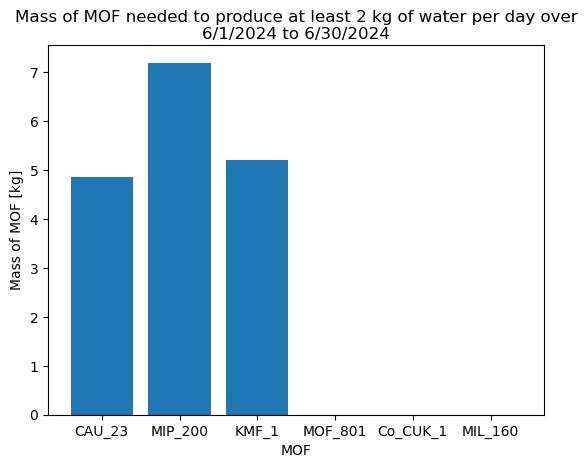

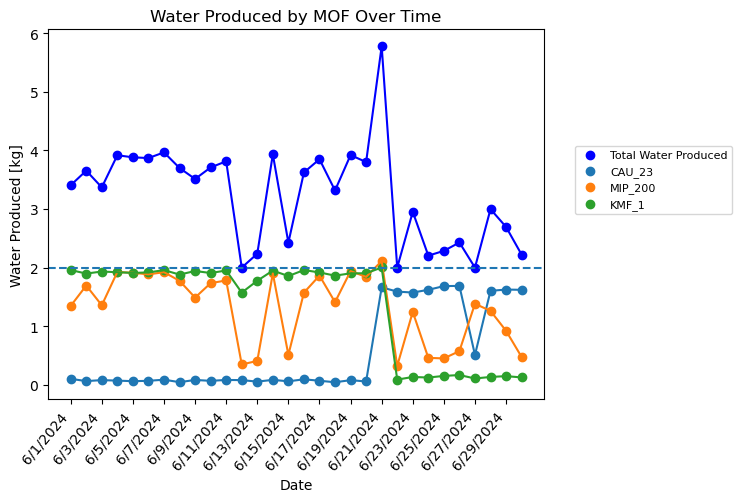

The mass of MOF needed to produce at least 2 kg of water per day over the time period is 17.282095612165204 kg
And the total mass of water produced over the time period is 97.47200477147292 kg
29


In [120]:
""""
    Optimize_MOF(date1,date2)
        Given a start and end date, find the rate of water produced by each MOF over the course of the time period 
        Then find the lowest mass of MOF needed to produce a certain amount of water over the time period

        date1 (string): mm/dd/yyyy
        date2 (string): mm/dd/yyyy
"""

def Optimize_MOF_v1(date1,date2):
    
    #convert dates to datetime objects
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)
    delta = date2 - date1
    delta = delta.days

    #create a list of dates in the range
    day_list = [date1 + pd.DateOffset(days=x) for x in range(delta+1)]
    day_list = [day.strftime('%#m/%#d/%Y') for day in day_list]

    
    #creqte the A_ub matrix that has the daily water production for each MOF 
    A_ub = np.zeros((len(day_list), len(MOFs)))
    for i_day, day in enumerate(day_list):
        for i_MOF, MOF in enumerate(MOFs):
            A_ub[i_day, i_MOF] = calculate_daily_ads(day, MOF, data_temperatures[i_MOF])

    #A_ub and b_ub are negative to make the constraint A_ub*x => b_ub
    A_ub = -A_ub
    target_water_mass = 2 # kg of water per day
    b_ub = -np.ones(len(day_list))*target_water_mass # Aub*x <= b_ub -> -Aub >= -b_ub
    c = np.ones(len(MOFs)) 

    res = linprog(c, A_ub, b_ub, method='highs')

    date1 = date1.strftime('%#m/%#d/%Y')
    date2 = date2.strftime('%#m/%#d/%Y')

    plt.bar(MOFs, res.x)
    plt.xlabel('MOF')
    plt.ylabel('Mass of MOF [kg]')
    plt.title(f'Mass of MOF needed to produce at least {target_water_mass} kg of water per day over {date1} to {date2}', loc='center', wrap=True)
    plt.show()

    Water_per_day = -A_ub * res.x
    Water_per_day_total = Water_per_day.sum(axis=1)
    plt.scatter(day_list, Water_per_day_total, color='blue',label = 'Total Water Produced')
    plt.plot(day_list, Water_per_day_total, color='blue')
    for i in range(len(MOFs)):
        if res.x[i] > 0:
            plt.scatter(day_list, Water_per_day[:,i],label = MOFs[i])
            plt.plot(day_list, Water_per_day[:,i])
    plt.axhline(target_water_mass, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Water Produced [kg]')
    plt.title('Water Produced by MOF Over Time')
    plt.xticks(day_list[::2],rotation=50, ha='right')
    plt.legend(bbox_to_anchor=(1.05,0.7),prop={'size': 8})
    plt.show()  
    
    print('The mass of MOF needed to produce at least',target_water_mass,'kg of water per day over the time period is',res.fun,'kg')
    print('And the total mass of water produced over the time period is',Water_per_day_total.sum(),'kg')
    print(delta)

Optimize_MOF_v1('6/1/2024','6/30/2024')